<a href="https://colab.research.google.com/github/ketan-lambat/DIP-Dehazing/blob/main/DIP_Dehazing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab_Work/DIP'

/content/gdrive/My Drive/Colab_Work/DIP


In [14]:
# Function to calculate the dark color channel
# having very low intensity at some pixels

def get_dark_channel(img, wind_size):
  dark_channel = np.zeros((img.shape[0], img.shape[1]))
  border_size = wind_size//2
  # cv2.copyMakeBorder() method 
  # is used to create a border around the image like a photo frame
  # cv2.copyMakeBorder(src, top, bottom, left, right, borderType, value)
  img = cv2.copyMakeBorder(img, 
                           border_size,
                           border_size,
                           border_size,
                           border_size,
                           cv2.BORDER_CONSTANT, 
                           value=[255, 255, 255])
  num_rows = img.shape[0]
  num_cols = img.shape[1]
  min_channel = np.zeros((num_rows, num_cols))

  for row in range(num_rows):
    for col in range(num_cols):
      min_channel[row-border_size][col-border_size] = np.min(img[row, col, :])

  for row in range(border_size, num_rows-border_size):
    for col in range(border_size, num_cols-border_size):
      dark_channel[row-border_size][col-border_size] = np.min(min_channel[row-border_size:row+border_size, col-border_size:col+border_size])
      
  return dark_channel

In [15]:
def get_atm_light(im, dark_channel_img):
  img = im.copy()
  num_pixels = dark_channel_img.size
  num_brightest = num_pixels//1000
  haze_density_sort_idx = np.argsort(dark_channel_img, axis=None)[::-1]
  
  brightest = haze_density_sort_idx[0:num_brightest]
  brightest = np.unravel_index(brightest,dark_channel_img.shape)
  
  brightest_pixels = img[brightest]
  top_intensities = np.average(brightest_pixels, axis=1)
  max_intensity = np.argmax(top_intensities)
  
  A = brightest_pixels[max_intensity]
  img[brightest]=[255,0,0]
  row_min = np.min(brightest[0])
  row_max = np.max(brightest[0])
  col_min = np.min(brightest[1])
  col_max = np.max(brightest[1])
  
  cv2.rectangle(img, 
                (col_min,row_min),
                (col_max,row_max),
                (0,0,255),
                thickness=2)
  
  plt.figure(figsize=(10,10))
  plt.imshow(img[...,::-1])
  plt.show()
  return A

In [16]:
def refine(img, transmission, radius, epsilon):
  mean_guide = cv2.blur(img,(radius,radius))
  mean_trans = cv2.blur(transmission,(radius,radius))
  mean_gt = cv2.blur(img * transmission, (radius,radius))
    
  a = mean_gt - mean_guide * mean_trans
  var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
  a = a/(var_guide + epsilon)
  b = mean_trans - a * mean_guide

  q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
  return q

In [17]:
def recover_image(img, trans_bar, atm_light, t0):
  trans_recover = np.copy(trans_bar)
  trans_recover[trans_recover < t0] = t0
  J = np.zeros((img.shape))

  J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
  J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
  J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
  
  return J


In [18]:
def color_balance(img, s):
  out = np.copy(img)
  hist = np.zeros((256,1))
  no_of_pixels = img.shape[0] * img.shape[1]

  for i in range(3):
    channel_vals = img[:,:,i]

    for pixel_val in range(256):
      hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
    for pixel_val in range(256):
      hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]
    Vmin = 0
    while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
      Vmin += 1
    Vmax = 255
    while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
      Vmax -= 1
    channel_vals[channel_vals < Vmin] = Vmin
    channel_vals[channel_vals > Vmax] = Vmax
    out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
  return out

In [23]:
def depth_map(t_refine, beta):
    x = -np.log(t_refine)/beta
    return x

In [28]:
def histEqual(im):
    ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    restored = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return restored

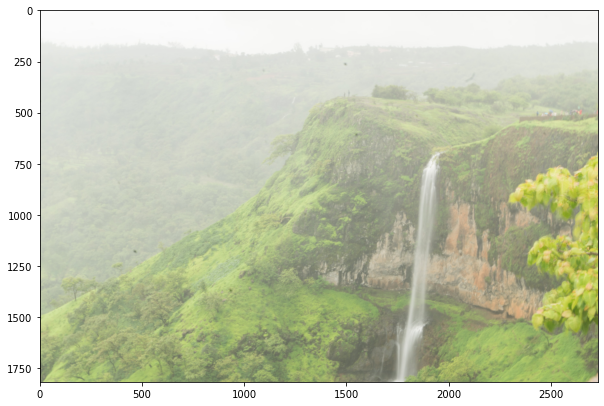

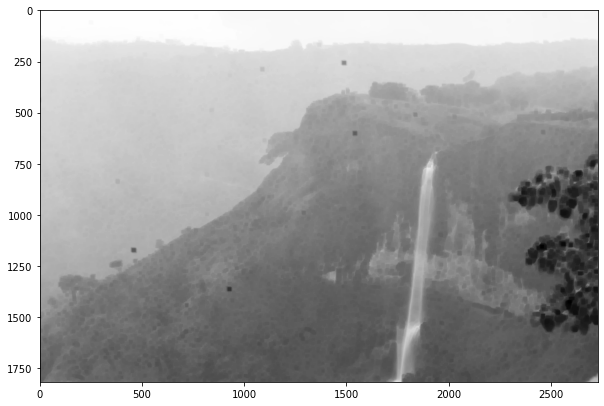

In [40]:
filename = "haze4.jpg"
img = cv2.imread(filename)
img = cv2.resize(img,(0,0),fx=0.5,fy=0.5)
plt.figure(figsize=(10,10))
plt.imshow(img[...,::-1])
plt.show()
dark_channel_img = get_dark_channel(img, 15)
dark_channel_img = dark_channel_img.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(dark_channel_img,'gray')
plt.show()

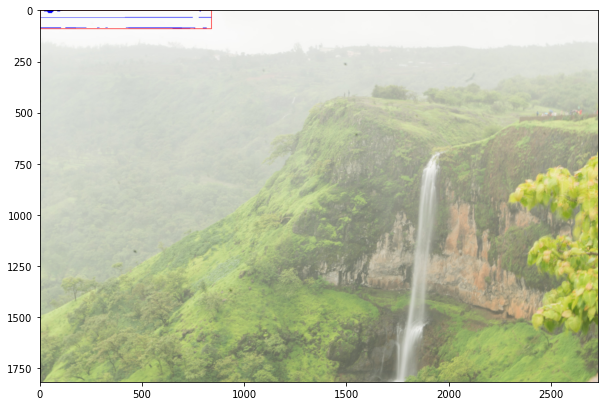

In [41]:
atm_light = get_atm_light(img, dark_channel_img)

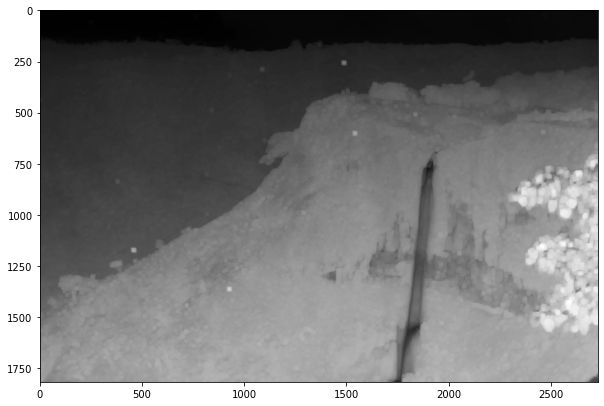

In [42]:
t_bar = get_dark_channel(img/atm_light,15)
trans_bar = 1-(0.85*t_bar)
plt.figure(figsize=(10,10))
plt.imshow(trans_bar,'gray')
plt.show()

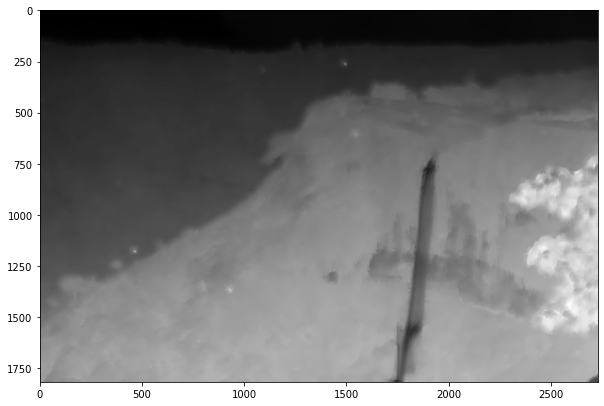

In [43]:
i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
t_refine = refine(i, trans_bar, 30, 0.0001)
plt.figure(figsize=(10,10))
plt.imshow(t_refine,'gray')
plt.show()

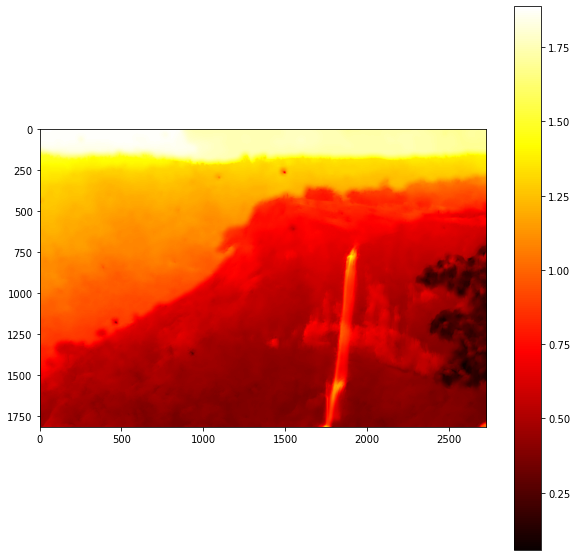

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(depth_map(t_refine, 1),'hot')
plt.colorbar()
plt.show()

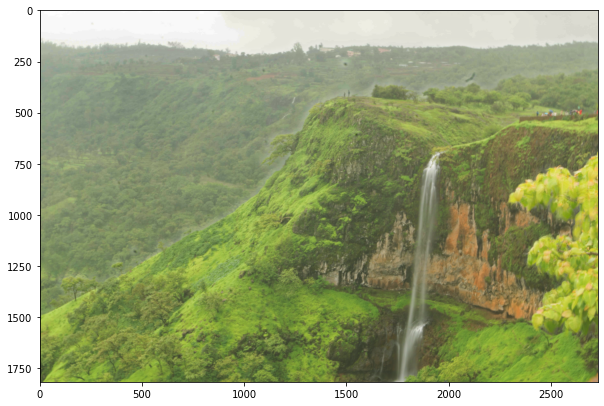

In [45]:
im = img.astype("double")
J = recover_image(im, t_refine, atm_light, 0.1)
J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(J[...,::-1])))
plt.show()

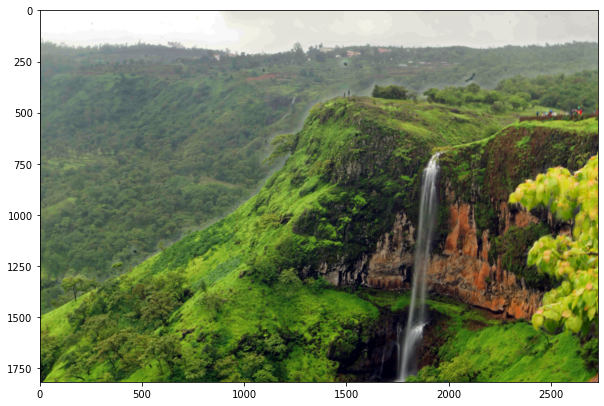

In [46]:
cb_J = color_balance(np.uint8(J),0.005)
plt.figure(figsize=(10,10))
plt.imshow((np.uint8(cb_J[...,::-1])))
plt.show()

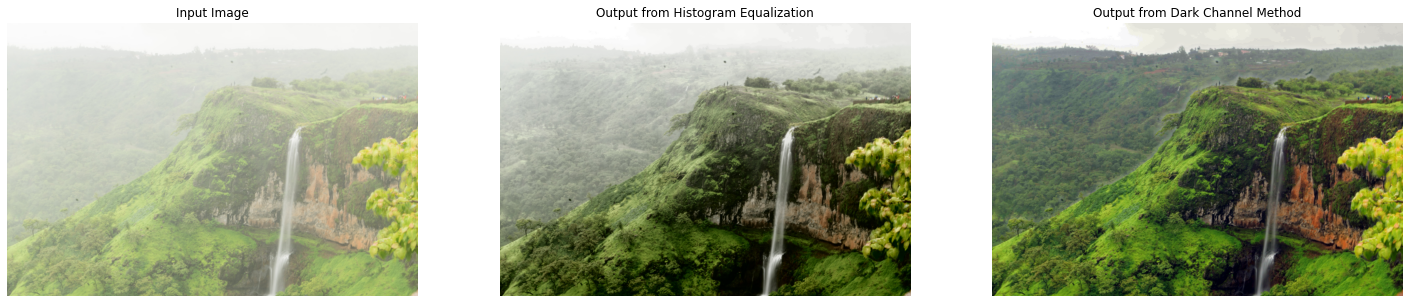

In [47]:
J = histEqual(img)

fig=plt.figure(figsize=(25,15))
ax=fig.add_subplot(131)
ax.imshow(img[...,::-1])
ax.set_title("Input Image")
ax.axis('off')

ax=fig.add_subplot(132)
ax.imshow(J[...,::-1])
ax.set_title("Output from Histogram Equalization")
ax.axis('off')

ax=fig.add_subplot(133)
ax.imshow(cb_J[...,::-1])
ax.set_title("Output from Dark Channel Method")
ax.axis('off')
plt.show()

In [48]:
name = filename.split('.')[0]
fig.savefig('./output/'+name+'_op.png', transparent=True, dpi=fig.dpi)